# Considerations

"Deep Reinforcement Learning at the Edge of the Statistical Precipice", Section A.3, mentions that "... also discuss bootstrap CIs but for reporting single task mean scores – however, 3-5 runs is a small sample size for bootstrapping: on Atari 100k, for achieving true coverage close to 95%, such CIs require at least 20-30 runs per task (Figure A.18) as opposed to 5-10 runs for stratified bootstrap CIs for aggregate metrics".

"How Many Random Seeds? Statistical Power Analysis in Deep Reinforcement Learning Experiments" proposes a multi-step process to find the minimal number of runs needed to arrive at a statistically significant result. However, they recommend a "pilot study" of $n=20$ runs to estimate parameters which are then used to calculate an appropriate number of runs for the statistical tests. Overall this approach again leads to a requirement of $N >= 20$ runs.

Further questions:
- Reference Rainbow implementation does not differentiate between training and testing, i.e. is always in train mode. Is this intended and should it also stay like this for evaluation?

In [6]:
import time, random
from collections import deque
from pathlib import Path
from types import SimpleNamespace as sn

import torch
import numpy as np
from tqdm import trange
from rich import print
from copy import copy

import wandb
from wandb.integration.sb3 import WandbCallback
from stable_baselines3.common.callbacks import EvalCallback

In [2]:
from rainbow import Rainbow, reset_noise

In [3]:
from env_wrappers import create_env
from utils import get_mean_ep_length, AgesLogger, WeightLogger
from sb3_logger import configure_logger, WandbOutputFormat

In [4]:
def set_random(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

In [5]:
def set_up_env(args):
    decorr_steps = None
    if args.decorr and args.env_name == 'gym:Breakout':
        decorr_steps = 160 // args.parallel_envs
    if args.decorr and not args.env_name.startswith('procgen:') and decorr_steps is None:
        decorr_steps = get_mean_ep_length(args) // args.parallel_envs
    env = create_env(args, decorr_steps=decorr_steps)
    
    return env

In [6]:
def initialize_model(args, env):
    model = Rainbow('CnnPolicy',
                    env,
                    buffer_size=args.buffer_size,
                    batch_size=args.batch_size,
                    learning_starts=args.burnin,
                    target_update_interval=args.sync_dqn_target_every,
                    gradient_steps=args.gradient_steps,
                    exploration_fraction=args.exploration_fraction,
                    policy_kwargs={
                        'noisy_linear': args.noisy_linear, 
                        'linear_kwargs': args.linear_kwargs, 
                        'optimizer_class': args.optimizer_class,
                        'optimizer_kwargs': args.optimizer_kwargs,
                        'features_extractor_kwargs': {'model_size': args.model_size}
                    })
    
    return model

In [7]:
def initialize_logging(args, model):
    run = wandb.init(
        project="Rainbow",
        group=args.wandb_group,
        name=args.name,
        config=vars(args),
        dir=args.wandb_dir,
        #monitor_gym=True,  # auto-upload the videos of agents playing the game
        mode=args.wandb_mode,
        #reinit=True
    )
    
    model.set_logger(configure_logger(0, args.tb_log_dir, args.name, True, extra_formats=[WandbOutputFormat]))
    
    callbacks = [WeightLogger(),
                 AgesLogger(args.ages_dir),
                 WandbCallback(gradient_save_freq=args.wandb_grad_freq)]
    
    if args.evalcallback:
        eval_args = copy(args)
        eval_args.seed += 1   # change seed to avoid data leakage if necessary
        eval_args.decorr = False
        eval_args.parallel_envs = eval_args.n_eval_episodes
        
        callbacks.append(EvalCallback(set_up_env(eval_args),
                                      n_eval_episodes=eval_args.n_eval_episodes,
                                      eval_freq=eval_args.eval_freq,
                                      log_path=eval_args.eval_log_path,
                                      best_model_save_path=eval_args.best_model_save_path,
                                      verbose=0))
    
    return run, callbacks

In [8]:
def train(args):
    set_random(args)
    
    env = set_up_env(args)
    model = initialize_model(args, env)
    run, callbacks = initialize_logging(args, model)
    
    try:
        model.learn(args.training_frames, callback=callbacks, tb_log_name=args.name, progress_bar=True)
        model.save(args.log_dir + 'final_model')
    except Exception as e:
        print(e)
    
    env.close()
    model.logger.close()
    run.finish()
    
    return model

In [1]:
def approximate_updates(args):
    return int(np.round(((args.training_frames // args.parallel_envs - (args.burnin // args.parallel_envs * 1.5)) * args.gradient_steps)))

def approximate_total_resets(args):
    '''Approximate number of CBP resets for a layer with 256 features (default)'''
    return int(np.round(args.optimizer_kwargs['rho'] * 256 * approximate_updates(args)))

def approximate_min_resetting_features(args):
    '''Approximate the number of features getting reset, if always the same are targeted'''
    return int(np.round(args.optimizer_kwargs['rho'] * 256 * args.optimizer_kwargs['m']))

In [3]:
from argparse import Namespace
args = Namespace(env_name='gym:Breakout',
                 parallel_envs=64,
                 subproc_vecenv=False,
                 time_limit=108_000,
                 frame_stack=4,
                 frame_skip=4,
                 grayscale=True,
                 gamma=0.99,
                 resolution=(84, 84),
                 save_dir='tmp',
                 record_every=60*50,
                 decorr=True,
                 seed=3605)

args.wandb_mode = 'online'
args.wandb_group = 'cbp' #'baseline'
args.name = '1M_cbp'
args.log_dir = './runs/' + args.name + '/'
args.ages_dir = args.log_dir + 'ages/'
args.wandb_dir = args.log_dir # 'wandb' added automatically    # TODO: Change Paths to os.join paths
args.tb_log_dir = args.log_dir + 'tensorboard'
args.wandb_grad_freq = 0

args.evalcallback = False  # Evaluation is synchronous and usually very slow, so it may be better to simply evaluate at the end
args.n_eval_episodes = 10
args.eval_freq = 150
args.eval_log_path = args.log_dir + 'eval/'
args.best_model_save_path = args.log_dir

args.burnin = 10_000
args.buffer_size = 2**17
args.batch_size = 256
args.sync_dqn_target_every = 32_000
args.training_frames = 1_000_000 #1000 #2_000_000

args.noisy_linear = False
args.linear_kwargs = {'sigma_0': 0.5} if args.noisy_linear else {}

args.eps_decay_frames = 500_000
args.exploration_fraction = args.eps_decay_frames / (args.training_frames + args.parallel_envs)
    
args.adam_eps = None
args.optimizer_kwargs = {'eps': args.adam_eps}
args.model_size = 2
args.gradient_steps = 2

if args.wandb_group == 'cbp':
    from cbp import CBP
    args.optimizer_class = CBP
    args.optimizer_kwargs |= {'m':1000, 'rho':1e-5}
else:
    from torch.optim import Adam
    args.optimizer_class = Adam

# ATTEMPTED: change eps and beta settings to be timestep based, not percentage
# PROBLEM: cannot change this, as the schedule is created in the constructor, but training_frames is only supplied once 'learn' is called
# SOLUTION: calculate appropriate fraction before passing it to the model

In [4]:
args.buffer_size, args.sync_dqn_target_every%args.parallel_envs == 0, args.training_frames

(131072, True, 1000000)

In [7]:
if args.wandb_group == 'cbp':
    print('Approximate Total Updates:', approximate_updates(args))
    print('Approximate Total Resets:', approximate_total_resets(args))
    print('Approximate Min resetted features:', approximate_min_resetting_features(args))

Approximate Total Updates: 30782

Approximate Total Resets: 79

Approximate Min resetted features: 3

In [13]:
args.training_frames // args.parallel_envs

16384

In [14]:
model = train(args)

wandb: Currently logged in as: hae_. Use `wandb login --relogin` to force relogin
wandb: WARNING Path ./runs/1M_cbp/wandb\ wasn't writable, using system temp directory.


Output()

rollout/ep_len_mean,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▄▅▆▇▇▇█
rollout/ep_rew_mean,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▄▄▅▇█
rollout/exploration_rate,██▇▇▇▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
rollout/prioritized_er_beta,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
time/episodes,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
time/fps,▃▆▇▇█████▆▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
time/time_elapsed,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▆▆▇▇█
time/total_timesteps,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▆▆▇▇█
timestep,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
train/grad_norm,▁▁▆▃▅█▂▃▄▄▄▃▃▂▃▂▃▄▂▃▃▂▂▁▁▂▁▂▂▁▂▂▂▂▃▂▂▁▂▁
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [15]:
if args.wandb_group != 'cbp':
    kaksfb

In [16]:
ages = {}
fhat = {}
h = {}
f = {}
u = {}
for branch, branch_name in zip(model.policy.optimizer.linear_layers, ['value', 'advantage']):
    for i, layer in enumerate(branch[:-1]):
        val = model.policy.optimizer.cbp_vals[layer]['age'].cpu().numpy()
        ages[f'{branch_name}_{i}'] = val
        fhat[f'{branch_name}_{i}'] = model.policy.optimizer.cbp_vals[layer]['fhat'].cpu().numpy()
        f[f'{branch_name}_{i}'] = model.policy.optimizer.cbp_vals[layer]['f'].cpu().numpy()
        h[f'{branch_name}_{i}'] = model.policy.optimizer.cbp_vals[layer]['h'].cpu().numpy()
        u[f'{branch_name}_{i}'] = model.policy.optimizer.cbp_vals[layer]['u'].cpu().numpy()

In [17]:
ages

{'value_0': array([29549, 26811, 19094, 29549, 29549, 28845, 29549, 29549, 20099,
        29549, 28556,   138, 29549, 29549,   659, 29549, 29549, 29549,
        29549, 29549, 24202, 26613, 29549, 22656, 29549, 28330, 29549,
        29549, 29549, 22226, 29549, 29549, 24615, 19982, 27475, 23196,
        29549, 29549, 29549, 29549, 29549, 26068, 29549, 29549, 29549,
         6468, 29549, 29549, 29549, 29549, 26839, 28670, 29549, 29549,
        22827, 29549, 29549, 29549, 29549, 29549, 28886, 29549, 29020,
        29549, 29549, 29549, 29549, 29549, 29549, 19692, 29549, 29549,
        29549, 29549, 29549, 27948, 29549, 29549, 29549, 29549, 17993,
        29549, 22695, 29549, 29549, 29549, 29549, 29549, 29549, 29549,
        27158, 29549, 29549, 15774, 29549, 22898, 27144, 28353, 29549,
         2852, 29549, 29549, 26008, 29549, 29549, 29549, 28170, 29549,
        29549, 16660, 24577, 29549, 29549, 27579, 29549, 29549, 29549,
        29549, 18786, 29549, 29549, 29549, 21785, 29549, 29549, 29

In [18]:
a = list(ages.values())[0]
(a < a.max()).sum()

83

In [19]:
import matplotlib.pyplot as plt

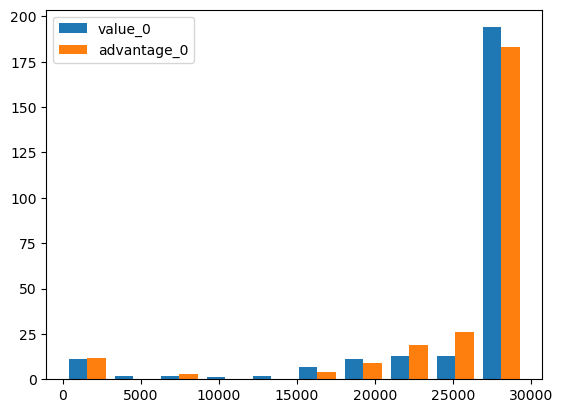

In [20]:
plt.hist(list(ages.values()), label=list(ages.keys()))
plt.legend()

In [1]:
import torch

In [2]:
lin = torch.nn.Linear(3, 4)

In [3]:
lin.training

True